<a href="https://colab.research.google.com/github/jeffveleze/age-calculator/blob/master/AgeCalculator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip3 install tensorflow==2.0

     |████████████████████████████████| 102.7 MB 283 kB/s eta 0:00:01
     |████████████████████████████████| 63 kB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 50 kB 2.5 MB/s eta 0:00:011
     |████████████████████████████████| 3.8 MB 3.5 MB/s eta 0:00:01
     |████████████████████████████████| 41 kB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 449 kB 3.5 MB/s eta 0:00:01
     |████████████████████████████████| 2.6 MB 3.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 3.7 MB/s eta 0:00:01
     |████████████████████████████████| 15.1 MB 3.7 MB/s eta 0:00:01
     |████████████████████████████████| 104 kB 129 kB/s eta 0:00:01
     |████████████████████████████████| 57 kB 645 kB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 298 kB 3.9 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 3.7 MB/s eta 0:00:01
     |████████████████████████████████| 87 kB 2.7

### Importing Libraries

In [6]:
from PIL import Image
# from __future__ import absolute_import, division, print_function, unicode_literals # Colab
exec('from __future__ import absolute_import, division, print_function, unicode_literals') # Local

# Helper libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import PIL
import pickle

# TensorFlow and tf.keras.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, MaxPool2D, MaxPooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

### Reading Data

In [8]:
# Define folder paths
# folder_base_dir = '/content/drive/My Drive/Age-Gender-Recognizer-Dataset/' # Colab
folder_base_dir = '/Users/jeffveleze/Dev/ML/Factored-AI/Datasets/AgeGenderDataSet/wikicrop1gb/' # Local

# Create local folder data path 
folder_data_path = folder_base_dir + '**'
folder_data_path = os.path.expanduser(folder_data_path)

# Create array with folder image addresses
folder_addresses = glob.glob(folder_data_path)

# Initialize image_addresses empty list
image_addresses = []

print("Started looping folders")

# Used to count loaded folders
current_folders_loaded = 0
max_folders_loaded = 2

# Loop all the folders to get the addresses
for folder_address in folder_addresses:
    files_extension = '.jpg'

    # Create folder address path object
    folder_address_path = folder_address + '/*' + files_extension
    folder_address_path = os.path.expanduser(folder_address_path)

    # Create array with image addresses
    image_addresses_per_folder = glob.glob(folder_address_path)
    image_addresses += image_addresses_per_folder

    # Control the number of folders loadead
#     current_folders_loaded += 1
#     if current_folders_loaded == max_folders_loaded:
#         break

print("Finished looping folders")

# Create function to extract data
def make_address_data(address):
    name_components = address.split('_')
    image_id = name_components[0].split('/')
    image_id = image_id[-1]
    birth_date = name_components[1]
    publish_date = name_components[2].replace(files_extension, '')
    birth_date_year = int(birth_date.split('-')[0])

    # Add a try-except when casting the publish_date
    try:
        publish_date_year = int(publish_date)
    except ValueError:
        # Handle the exception
        return (-1, -1, -1, -1, -1)

    age = publish_date_year - birth_date_year

    return (image_id, birth_date, birth_date_year, publish_date_year, age)

# Create initial values
RESIZED_WIDTH = 224
RESIZED_HEIGHT = 224
addresses = []
image_ids = []
birth_dates = []
birth_date_years = []
publish_date_years = []
ages = []
data_extraction_fails = 0

print("Started filling lists")

for address in image_addresses:
    image_id, birth_date, birth_date_year, publish_date_year, age = make_address_data(address)

    # Count filtered images bcz of wrong name
    if image_id == -1 and birth_date == -1:
        data_extraction_fails += 1

    if age > 0 and age < 100:

        # Appending path taken values
        addresses.append(address)
        image_ids.append(image_id)
        birth_dates.append(birth_date)
        birth_date_years.append(birth_date_year)
        publish_date_years.append(publish_date_year)
        ages.append(age)

print("Finished filling lists")
print("Files with wrong names:", data_extraction_fails)

np.array(ages).shape

Started looping folders
Finished looping folders
Started filling lists
Finished filling lists
Files with wrong names: 0


(60408,)

### Exploring Data

In [9]:
# Create dictionary arrays
images_dictionary = {'image_address': addresses, 'age' : ages}
images_data_frame = pd.DataFrame(images_dictionary)

# Visualize dataframe
images_data_frame.head()

,image_address,age
0,/Users/jeffveleze/Dev/ML/Factored-AI/Datasets/...,27
1,/Users/jeffveleze/Dev/ML/Factored-AI/Datasets/...,31
2,/Users/jeffveleze/Dev/ML/Factored-AI/Datasets/...,32
3,/Users/jeffveleze/Dev/ML/Factored-AI/Datasets/...,32
4,/Users/jeffveleze/Dev/ML/Factored-AI/Datasets/...,57


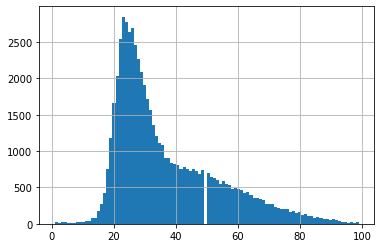

In [10]:
images_data_frame['age'].hist(bins = 100)            

In [11]:
images_data_frame.describe()

,age
count,60408.000000
mean,36.957439
std,16.608204
min,1.000000
25%,25.000000
50%,31.000000
75%,47.000000
max,99.000000


### Splitting Data

In [12]:
# Separating X and Y columns
X_df = images_data_frame['image_address'].copy()
Y_df = images_data_frame['age'].copy()

# Splitting train and test data
train_image_addresses, test_image_addresses, train_labels, test_labels = train_test_split(X_df, 
                                                                                          Y_df, 
                                                                                          test_size = 0.1, 
                                                                                          random_state = 2)

# Creating train and test dataframes
train_dictionary = {'train_image_addresses': train_image_addresses, 'train_labels' : train_labels}
test_dictionary = {'test_image_addresses': test_image_addresses, 'test_labels' : test_labels}
train_df = pd.DataFrame(train_dictionary)
test_df = pd.DataFrame(test_dictionary)

# Verifying correct shape
print(train_df.shape)
print(test_df.shape)

(54367, 2)
(6041, 2)


In [13]:
# Define random number to display image
image_index = 20

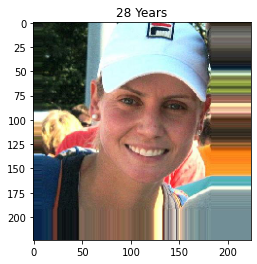

In [14]:
# Transforming images into matrixes and applying resizing
test_image_addresses_list = test_image_addresses.tolist()
test_labels_list = test_labels.tolist()
image = Image.open(test_image_addresses_list[image_index])
image = image.resize((RESIZED_WIDTH, RESIZED_HEIGHT), Image.NEAREST)
image_matrix = np.asarray(image.convert('RGB'))

# Normalizing image_matrix
image_matrix = image_matrix / 255

# Drawing train_images[image_index]
plt.figure()
plt.title(str(test_labels_list[image_index]) + " Years")
plt.imshow(image, cmap = plt.cm.binary)
plt.grid(False)
plt.show()

### Defining Hyperparameters

In [15]:
# Defining hyperparameters
hyperparams = {'dense' : 4, 
               'units': 256, 
               'activation' : 'relu', 
               'dropout': 0.15}

# Defining epochs and batch_size
batch_size = 32
epochs = 10 

### Creating Generators

In [16]:
validation_split = 0.1

# Generators for our data
# train_image_generator = ImageDataGenerator(
#     rotation_range = 60,
#     brightness_range = [0.5, 1.0],
#     zoom_range = [0.5, 1.0],
#     horizontal_flip = True,
#     vertical_flip = True,
#     rescale = 1./255,
#     validation_split = validation_split
# )

train_image_generator = ImageDataGenerator(
    rescale = 1./255,
    validation_split = validation_split
)

test_image_generator = ImageDataGenerator(rescale = 1./255)

In [17]:
# Load images from the disk, applies rescaling and resizes for train, validation and test
train_data_gen = train_image_generator.flow_from_dataframe(dataframe = train_df,
                                                           x_col = 'train_image_addresses',
                                                           y_col = 'train_labels',
                                                           batch_size = batch_size,
                                                           shuffle = False,
                                                           target_size = (RESIZED_WIDTH, RESIZED_HEIGHT),
                                                           class_mode = 'raw',
                                                           subset = 'training')

validation_data_gen = train_image_generator.flow_from_dataframe(dataframe = train_df,
                                                           x_col = 'train_image_addresses',
                                                           y_col = 'train_labels',
                                                           batch_size = batch_size,
                                                           shuffle = False,
                                                           target_size = (RESIZED_WIDTH, RESIZED_HEIGHT),
                                                           class_mode = 'raw',
                                                           subset = 'validation')

test_data_gen = test_image_generator.flow_from_dataframe(dataframe = test_df,
                                                         x_col = 'test_image_addresses',
                                                         y_col = 'test_labels',
                                                         batch_size = batch_size,
                                                         shuffle = False,
                                                         target_size = (RESIZED_WIDTH, RESIZED_HEIGHT),
                                                         class_mode = 'raw')

train_df_size = train_df.shape[0]

Found 48931 validated image filenames.
Found 5436 validated image filenames.
Found 6041 validated image filenames.


### Fully Connected Functional Model

In [54]:
# Load the model
functional_model = keras.models.load_model("functional_model.h5")

# # Load the history
with open('fm.serialized','rb') as file_object:
    fmh_raw_data = file_object.read()

fmh_dict = pickle.loads(fmh_raw_data)

functional_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 150528)       0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          38535424    flatten[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256)          0           dense[0][0]                      
______________________________________________________________________________________________

In [12]:
# Adding function to create functional model
def make_functional_model(hyperparams):

    inputs = tf.keras.Input(shape = (RESIZED_WIDTH, RESIZED_HEIGHT, 3))
    x1 = tf.keras.layers.Flatten()(inputs)
    x = x1

    units = hyperparams['units']
  
    # Inserting new layers 
    while units >= 8:
        x = tf.keras.layers.Dense(units, activation = hyperparams['activation'])(x)
        x = tf.keras.layers.Dropout(hyperparams['dropout'])(x)
        units /= 2

    x2 = tf.keras.layers.Dense(32)(x1)
    x = tf.keras.layers.Concatenate()([x, x2])
    outputs = tf.keras.layers.Dense(1)(x)

    functional_model = tf.keras.Model(inputs = inputs, outputs = outputs)
  
    return functional_model

In [13]:
# Creating model
functional_model = make_functional_model(hyperparams)

# Compiling models
functional_model.compile(optimizer = 'adam',
                         loss = 'mse',
                         metrics = ['mae'])

functional_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 150528)       0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          38535424    flatten[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256)          0           dense[0][0]                      
______________________________________________________________________________________________

In [14]:
# Training the model
fm_history = functional_model.fit_generator(
    train_data_gen,
    steps_per_epoch = train_df_size // batch_size,
    validation_data = validation_data_gen,
    validation_steps = train_df_size // batch_size,
    epochs = epochs
)

fmh_dict = fm_history.history

Epoch 1/10
16/16 [==============================] - 5s 336ms/step - loss: 33905.5188 - mae: 140.2636 - val_loss: 4201.2007 - val_mae: 60.7355
Epoch 2/10
16/16 [==============================] - 5s 307ms/step - loss: 4120.5799 - mae: 51.7619 - val_loss: 2429.0194 - val_mae: 42.4071
Epoch 3/10
16/16 [==============================] - 5s 312ms/step - loss: 1120.5676 - mae: 27.2274 - val_loss: 804.4350 - val_mae: 23.0453
Epoch 4/10
16/16 [==============================] - 5s 317ms/step - loss: 598.7308 - mae: 19.4231 - val_loss: 533.0187 - val_mae: 19.2710
Epoch 5/10
16/16 [==============================] - 5s 326ms/step - loss: 385.5833 - mae: 15.9233 - val_loss: 423.7147 - val_mae: 15.4433
Epoch 6/10
16/16 [==============================] - 5s 324ms/step - loss: 393.7739 - mae: 15.6718 - val_loss: 440.2278 - val_mae: 15.7881
Epoch 7/10
16/16 [==============================] - 5s 328ms/step - loss: 358.1901 - mae: 15.1742 - val_loss: 396.9769 - val_mae: 15.5289
Epoch 8/10
16/16 [=========

In [68]:
# Save the Model
functional_model.save("functional_model.h5")

# Save the history
fmh_serialized = pickle.dumps(fm_history.history)

with open('fm.serialized', 'wb') as file_object:
    file_object.write(fmh_serialized)

In [55]:
# Print resulting functional_model metrics for train
train_mse_fm, train_mae_fm = functional_model.evaluate_generator(train_data_gen)

print("Train MSE Functional Model: {}".format(train_mse_fm))
print("Train MAE Functional Model: {}".format(train_mae_fm))

Train MSE Functional Model: 254.07591173725743
Train MAE Functional Model: 11.738391876220703


In [56]:
# Print resulting functional_model metrics for test
test_mse_fm, test_mae_fm = functional_model.evaluate_generator(test_data_gen)

print("Test MSE Functional Model: {}".format(test_mse_fm))
print("Test MAE Functional Model: {}".format(test_mae_fm))

Test MSE Functional Model: 265.9634323120117
Test MAE Functional Model: 12.206039428710938


In [57]:
# Predicting with test data
predicted_labels_fm = functional_model.predict_generator(test_data_gen)

# Calculating some more metrics
test_mse_fm = mean_squared_error(test_labels, predicted_labels_fm)
print("Mean Square Error (MSE)= {:.2f}".format(test_mse_fm))

test_mae_fm = mean_absolute_error(test_labels, predicted_labels_fm)
print("Mean Absolute Error (MAE)= {:.2f}".format(test_mae_fm))

test_r2_fm = r2_score(test_labels, predicted_labels_fm)
print("R_2 = {:.3f}".format(test_r2_fm))

Mean Square Error (MSE)= 269.54
Mean Absolute Error (MAE)= 12.21
R_2 = -0.052


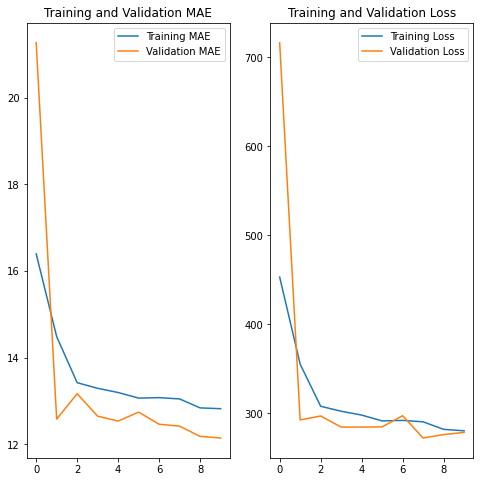

In [58]:
# Visualizing MAE and Loss for Training and Validation Sets
mae = fmh_dict['mae']
val_mae = fmh_dict['val_mae']

loss = fmh_dict['loss']
val_loss = fmh_dict['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label = 'Training MAE')
plt.plot(epochs_range, val_mae, label = 'Validation MAE')
plt.legend(loc = 'upper right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

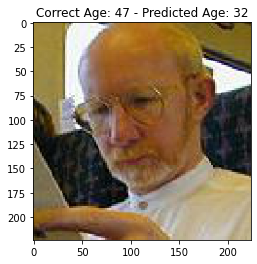

In [59]:
# Visualizing model predictions

# Transforming images into matrixes and applying resizing
test_image_addresses_list = test_image_addresses.tolist()
test_labels_list = test_labels.tolist()
predicted_test_labels_list = predicted_labels_fm.tolist()

correct_age = test_labels_list[image_index]
predicted_age = predicted_test_labels_list[image_index][0]

image = Image.open(test_image_addresses_list[image_index])
image = image.resize((RESIZED_WIDTH, RESIZED_HEIGHT), Image.NEAREST)
image_matrix = np.asarray(image.convert('RGB'))

# Normalizing image_matrix
image_matrix = image_matrix / 255

# Drawing train_images[image_index]
plt.figure()
plt.title(str(test_labels_list[image_index]) + " Years")
title = "Correct Age: " + str(correct_age) + " - Predicted Age: " + str(int(predicted_age))
plt.title(title)
plt.imshow(image, cmap = plt.cm.binary)
plt.grid(False)
plt.show()

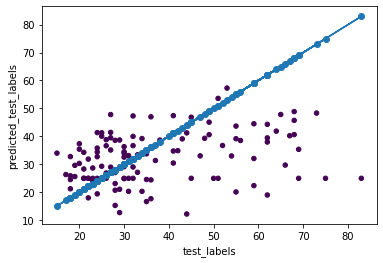

In [60]:
# Visualizing expected vs real data
N = len(test_labels)
colors = [0.8] * N
area = 20

plt.scatter(test_labels, predicted_labels_fm, s = area, c = colors)
plt.plot(test_labels, test_labels, '-o')
plt.xlabel("test_labels")
plt.ylabel("predicted_test_labels")
plt.show()

### Fully Connected Sequential Model

In [48]:
# Load the model
sequential_model = keras.models.load_model("sequential_model.h5")

# # Load the history
with open('sm.serialized','rb') as file_object:
    smh_raw_data = file_object.read()

smh_dict = pickle.loads(smh_raw_data)

sequential_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               38535424  
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0

In [29]:
# Adding function to create sequential model
def make_sequential_model(hyperparams):

    layers_list = []
    layers_list.append(
        tf.keras.layers.Flatten(input_shape = (RESIZED_WIDTH, RESIZED_HEIGHT, 3))
    )

    units = hyperparams['units']

    # Inserting new layers 
    while units >= 8:
        layers_list.append(tf.keras.layers.Dense(units, activation = hyperparams['activation']))
        layers_list.append(tf.keras.layers.Dropout(hyperparams['dropout']))
        units /= 2

    # No activation function is used for the output layer because it's a 
    # regression problem and we are interested in predicting numerical values 
    # directly without transform.
    layers_list.append(tf.keras.layers.Dense(1))
    sequential_model = tf.keras.models.Sequential(layers_list)

    return sequential_model

In [19]:
# Creating model
sequential_model = make_sequential_model(hyperparams)

# Compiling model
sequential_model.compile(optimizer = 'adam',
                         loss = 'mse',
                         metrics = ['mae'])

sequential_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               38535424  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0

In [30]:
# Training the model
sm_history = sequential_model.fit_generator(
    train_data_gen,
    steps_per_epoch = train_df_size // batch_size,
    validation_data = validation_data_gen,
    validation_steps = train_df_size // batch_size,
    epochs = epochs
)

smh_dict = sm_history.history

Epoch 1/20
1681/1681 [==============================] - 661s 393ms/step - loss: 465.1936 - mae: 16.4906 - val_loss: 499.3247 - val_mae: 16.7492
Epoch 2/20
1681/1681 [==============================] - 822s 489ms/step - loss: 373.3656 - mae: 14.6858 - val_loss: 433.0614 - val_mae: 14.9726
Epoch 3/20
1681/1681 [==============================] - 993s 591ms/step - loss: 343.7105 - mae: 13.9376 - val_loss: 379.2610 - val_mae: 13.8451
Epoch 4/20
1681/1681 [==============================] - 757s 450ms/step - loss: 308.9635 - mae: 13.2644 - val_loss: 313.7471 - val_mae: 12.3725
Epoch 5/20
1681/1681 [==============================] - 872s 518ms/step - loss: 292.2718 - mae: 13.0023 - val_loss: 249.2567 - val_mae: 11.9435
Epoch 6/20
1681/1681 [==============================] - 820s 488ms/step - loss: 288.8092 - mae: 13.0422 - val_loss: 247.8156 - val_mae: 11.9741
Epoch 7/20
1681/1681 [==============================] - 623s 371ms/step - loss: 280.5346 - mae: 12.8315 - val_loss: 243.7447 - val_mae: 

In [31]:
# Save the Model
sequential_model.save("sequential_model.h5")

# Save the history
smh_serialized = pickle.dumps(sm_history.history)

with open('sm.serialized', 'wb') as file_object:
    file_object.write(smh_serialized)

In [49]:
# Print resulting sequential_model metrics for train
train_mse_sm, train_mae_sm = sequential_model.evaluate_generator(train_data_gen)

print("Train MSE Sequential Model: {}".format(train_mse_sm))
print("Train MAE Sequential Model: {}".format(train_mae_sm))

Train MSE Sequential Model: 232.77144598191785
Train MAE Sequential Model: 11.473748207092285


In [50]:
# Print resulting sequential_model metrics for test
test_mse_sm, test_mae_sm = sequential_model.evaluate_generator(test_data_gen)

print("Test MSE Sequential Model: {}".format(test_mse_sm))
print("Test MAE Sequential Model: {}".format(test_mae_sm))

Test MSE Sequential Model: 231.46539688110352
Test MAE Sequential Model: 11.623175621032715


In [51]:
# Predicting with test data
predicted_labels_sm = sequential_model.predict_generator(test_data_gen)

# Calculating some more metrics
test_mse_sm = mean_squared_error(test_labels, predicted_labels_sm)
print("Mean Square Error (MSE)= {:.2f}".format(test_mse_sm))

test_mae_sm = mean_absolute_error(test_labels, predicted_labels_sm)
print("Mean Absolute Error (MAE)= {:.2f}".format(test_mae_sm))

test_r2_sm = r2_score(test_labels, predicted_labels_sm)
print("R_2 = {:.3f}".format(test_r2_sm))

Mean Square Error (MSE)= 234.10
Mean Absolute Error (MAE)= 11.62
R_2 = 0.087


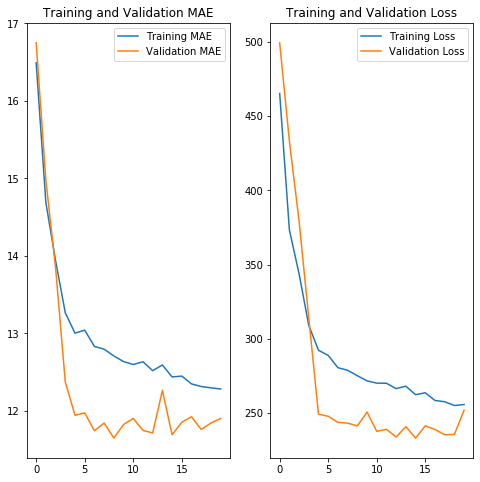

In [28]:
# Visualizing MAE and Loss for Training and Validation Sets
mae = smh_dict['mae']
val_mae = smh_dict['val_mae']

loss = smh_dict['loss']
val_loss = smh_dict['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label = 'Training MAE')
plt.plot(epochs_range, val_mae, label = 'Validation MAE')
plt.legend(loc = 'upper right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

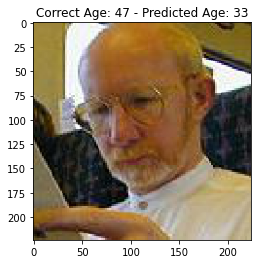

In [52]:
# Visualizing model predictions

# Transforming images into matrixes and applying resizing
test_image_addresses_list = test_image_addresses.tolist()
test_labels_list = test_labels.tolist()
predicted_test_labels_list = predicted_labels_sm.tolist()

correct_age = test_labels_list[image_index]
predicted_age = predicted_test_labels_list[image_index][0]

image = Image.open(test_image_addresses_list[image_index])
image = image.resize((RESIZED_WIDTH, RESIZED_HEIGHT), Image.NEAREST)
image_matrix = np.asarray(image.convert('RGB'))

# Normalizing image_matrix
image_matrix = image_matrix / 255

# Drawing train_images[image_index]
plt.figure()
plt.title(str(test_labels_list[image_index]) + " Years")
title = "Correct Age: " + str(correct_age) + " - Predicted Age: " + str(int(predicted_age))
plt.title(title)
plt.imshow(image, cmap = plt.cm.binary)
plt.grid(False)
plt.show()

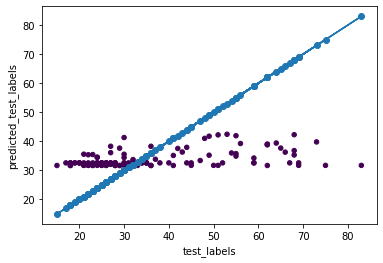

In [53]:
# Visualizing expected vs real data
N = len(test_labels)
colors = [0.8] * N
area = 20

plt.scatter(test_labels, predicted_labels_sm, s = area, c = colors)
plt.plot(test_labels, test_labels, '-o')
plt.xlabel("test_labels")
plt.ylabel("predicted_test_labels")
plt.show()

### CNN Model

In [18]:
# Load the model
cnn_model = keras.models.load_model("cnn_model_dropout.h5")

# # Load the history
with open('cnnmd.serialized','rb') as file_object:
    cnnmh_raw_data = file_object.read()

cnnmh_dict = pickle.loads(cnnmh_raw_data)

cnn_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 16)      64        
_________________________________________________________________
activation (Activation)      (None, 224, 224, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640  

In [14]:
# Define function to create CNN

def create_cnn(width, height, depth, filters = (16, 32, 64)):
    inputShape = (height, width, depth)
    chanDim = -1

    # Define the model input
    inputs = Input(shape = inputShape)

    # Loop over the number of filters
    for (i, f) in enumerate(filters):
    
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs

        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding = "same")(x)
        x = BatchNormalization(axis = chanDim)(x)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size = (2, 2))(x)
        x = Dropout(0.3)(x)

    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(512)(x)
    x = BatchNormalization(axis = chanDim)(x)
    x = Activation("relu")(x)
    x = Dropout(0.5)(x)


    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(16)(x)
    x = Activation("relu")(x)

    x = Dense(1)(x)

    # construct the CNN
    model = Model(inputs, x)

    # return the CNN
    return model

In [15]:
# Creating CNN
cnn_model = create_cnn(RESIZED_WIDTH, RESIZED_HEIGHT, 3)

# Compile model
cnn_model.compile(optimizer = 'adam',
                  loss = 'mse',
                  metrics = ['mae'])

cnn_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 16)      64        
_________________________________________________________________
activation (Activation)      (None, 224, 224, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640  

In [16]:
# Training the model
cnnm_history = cnn_model.fit_generator(
    train_data_gen,
    steps_per_epoch = train_df_size // batch_size,
    validation_data = validation_data_gen,
    validation_steps = train_df_size // batch_size,
    epochs = epochs
)

cnnmh_dict = cnnm_history.history

Epoch 1/10
1698/1698 [==============================] - 2759s 2s/step - loss: 249.8267 - mae: 11.9782 - val_loss: 387.7588 - val_mae: 16.7798
Epoch 2/10
1698/1698 [==============================] - 2911s 2s/step - loss: 208.8998 - mae: 10.9308 - val_loss: 201.0016 - val_mae: 11.2738
Epoch 3/10
1698/1698 [==============================] - 2879s 2s/step - loss: 195.4964 - mae: 10.5241 - val_loss: 182.7560 - val_mae: 10.4238
Epoch 4/10
1698/1698 [==============================] - 2830s 2s/step - loss: 187.9225 - mae: 10.3169 - val_loss: 186.4131 - val_mae: 10.7694
Epoch 5/10
1698/1698 [==============================] - 3180s 2s/step - loss: 177.8569 - mae: 9.9797 - val_loss: 182.4356 - val_mae: 10.7094
Epoch 6/10
1698/1698 [==============================] - 3055s 2s/step - loss: 171.1633 - mae: 9.7530 - val_loss: 171.6624 - val_mae: 9.9947
Epoch 7/10
1698/1698 [==============================] - 2744s 2s/step - loss: 164.1499 - mae: 9.5328 - val_loss: 171.9189 - val_mae: 9.6877
Epoch 8/10


In [17]:
# Save the Model
cnn_model.save("cnn_model.h5")

# Save the history
cnnmh_serialized = pickle.dumps(cnnm_history.history)

with open('cnnm.serialized', 'wb') as file_object:
    file_object.write(cnnmh_serialized)

In [21]:
# Print resulting cnn_model metrics for train
train_mse_cnnm, train_mae_cnnm = cnn_model.evaluate_generator(train_data_gen)

print("Train MSE CNN Model: {}".format(train_mse_cnnm))
print("Train MAE CNN Model: {}".format(train_mae_cnnm))

Train MSE CNN Model: 120.57110463560016
Train MAE CNN Model: 8.082114219665527


In [22]:
# Print resulting cnn_model metrics for test
test_mse_cnnm, test_mae_cnnm = cnn_model.evaluate_generator(test_data_gen)

print("Test MSE CNN Model: {}".format(test_mse_cnnm))
print("Test MAE CNN Model: {}".format(test_mae_cnnm))

Test MSE CNN Model: 160.684994591607
Test MAE CNN Model: 9.51693344116211


In [23]:
# Predicting with test data
predicted_labels_cnnm = cnn_model.predict_generator(test_data_gen)

# Calculating some more metrics
test_mse_cnnm = mean_squared_error(test_labels, predicted_labels_cnnm)
print("Mean Square Error (MSE)= {:.2f}".format(test_mse_cnnm))

test_mae_cnnm = mean_absolute_error(test_labels, predicted_labels_cnnm)
print("Mean Absolute Error (MAE)= {:.2f}".format(test_mae_cnnm))

test_r2_cnnm = r2_score(test_labels, predicted_labels_cnnm)
print("R_2 = {:.3f}".format(test_r2_cnnm))

Mean Square Error (MSE)= 160.69
Mean Absolute Error (MAE)= 9.52
R_2 = 0.412


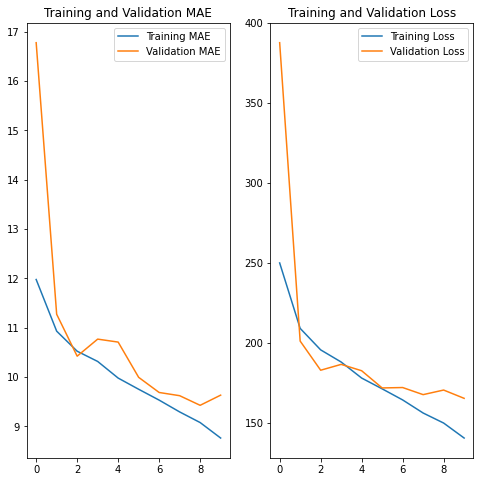

In [24]:
# Visualizing MAE and Loss for Training and Validation Sets
mae = cnnmh_dict['mae']
val_mae = cnnmh_dict['val_mae']

loss = cnnmh_dict['loss']
val_loss = cnnmh_dict['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label = 'Training MAE')
plt.plot(epochs_range, val_mae, label = 'Validation MAE')
plt.legend(loc = 'upper right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

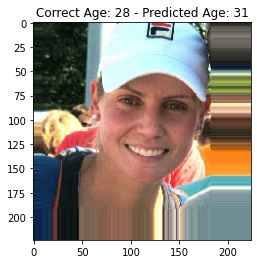

In [25]:
# Visualizing model predictions

# Transforming images into matrixes and applying resizing
test_image_addresses_list = test_image_addresses.tolist()
test_labels_list = test_labels.tolist()
predicted_test_labels_list = predicted_labels_cnnm.tolist()

correct_age = test_labels_list[image_index]
predicted_age = predicted_test_labels_list[image_index][0]

image = Image.open(test_image_addresses_list[image_index])
image = image.resize((RESIZED_WIDTH, RESIZED_HEIGHT), Image.NEAREST)
image_matrix = np.asarray(image.convert('RGB'))

# Normalizing image_matrix
image_matrix = image_matrix / 255

# Drawing train_images[image_index]
plt.figure()
plt.title(str(test_labels_list[image_index]) + " Years")
title = "Correct Age: " + str(correct_age) + " - Predicted Age: " + str(int(predicted_age))
plt.title(title)
plt.imshow(image, cmap = plt.cm.binary)
plt.grid(False)
plt.show()

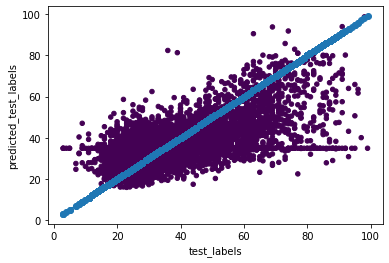

In [26]:
# Visualizing expected vs real data
N = len(test_labels)
colors = [0.8] * N
area = 20

plt.scatter(test_labels, predicted_labels_cnnm, s = area, c = colors)
plt.plot(test_labels, test_labels, '-o')
plt.xlabel("test_labels")
plt.ylabel("predicted_test_labels")
plt.show()

### CNN Model VGG-16 Architecture Classification

In [38]:
# Load the model
vgg16_cnn_model = keras.models.load_model("vgg16_cnn_model.h5")

# # Load the history
with open('vgg16_cnnm.serialized','rb') as file_object:
    smh_raw_data = file_object.read()

vgg16_cnnmh_dict = pickle.loads(smh_raw_data)

vgg16_cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 56, 56, 256)      

In [27]:
def make_VGG16_cnn_model(hyperparams):
    model = Sequential()

    model.add(Conv2D(input_shape=(RESIZED_WIDTH,RESIZED_HEIGHT,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Flatten())
    model.add(Dense(units=4096,activation="relu"))
    model.add(Dense(units=4096,activation="relu"))
    model.add(Dense(units=101, activation="softmax"))

    return model

In [28]:
# Creating model
vgg16_cnn_model = make_VGG16_cnn_model(hyperparams)

# Compiling model
vgg16_cnn_model.compile(optimizer = 'adam', 
                        loss = 'sparse_categorical_crossentropy', 
                        metrics = ['accuracy'])

vgg16_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       2

In [28]:
# Training the model
vgg16_cnnm_history = vgg16_cnn_model.fit_generator(steps_per_epoch = train_df_size // batch_size,
                                                   generator = train_data_gen, 
                                                   validation_data = validation_data_gen, 
                                                   validation_steps = train_df_size // batch_size, 
                                                   epochs = epochs)

vgg16_cnnmh_dict = vgg16_cnnm_history.history

Epoch 1/10
173/173 [==============================] - 4365s 25s/step - loss: 4.1446 - accuracy: 0.0470 - val_loss: 4.0099 - val_accuracy: 0.0380
Epoch 2/10
173/173 [==============================] - 4163s 24s/step - loss: 3.9815 - accuracy: 0.0469 - val_loss: 4.0116 - val_accuracy: 0.0251
Epoch 3/10
173/173 [==============================] - 4272s 25s/step - loss: 3.9893 - accuracy: 0.0496 - val_loss: 4.0028 - val_accuracy: 0.0553
Epoch 4/10
173/173 [==============================] - 4166s 24s/step - loss: 3.9684 - accuracy: 0.0483 - val_loss: 4.0096 - val_accuracy: 0.0504
Epoch 5/10
173/173 [==============================] - 4134s 24s/step - loss: 3.9725 - accuracy: 0.0467 - val_loss: 3.9988 - val_accuracy: 0.0553
Epoch 6/10
173/173 [==============================] - 4120s 24s/step - loss: 3.9854 - accuracy: 0.0438 - val_loss: 4.0085 - val_accuracy: 0.0504
Epoch 7/10
173/173 [==============================] - 4012s 23s/step - loss: 3.9765 - accuracy: 0.0487 - val_loss: 4.0092 - val_ac

In [30]:
# Save the Model
vgg16_cnn_model.save("vgg16_cnn_model.h5")

# Save the history
vgg16_cnnmh_serialized = pickle.dumps(vgg16_cnnm_history.history)

with open('vgg16_cnnm.serialized', 'wb') as file_object:
    file_object.write(vgg16_cnnmh_serialized)

In [39]:
# Print resulting cnn_model metrics for train
train_scce_vgg16_cnnm, train_accuracy_vgg16_cnnm = vgg16_cnn_model.evaluate_generator(train_data_gen)

print("Train Sparse Categorical Cross Entropy VGG16 CNN Model: {}".format(train_scce_vgg16_cnnm))
print("Train Accuracy VGG16 CNN Model: {}".format(train_accuracy_vgg16_cnnm))

Train Sparse Categorical Cross Entropy VGG16 CNN Model: 4.009357070513414
Train Accuracy VGG16 CNN Model: 0.045421700924634933


In [40]:
# Print resulting cnn_model metrics for test
test_scce_vgg16_cnnm, test_accuracy_vgg16_cnnm = vgg16_cnn_model.evaluate_generator(test_data_gen)

print("Test Sparse Categorical Cross Entropy VGG16 CNN Model: {}".format(test_scce_vgg16_cnnm))
print("Test Accuracy VGG16 CNN Model: {}".format(test_accuracy_vgg16_cnnm))

Test Sparse Categorical Cross Entropy VGG16 CNN Model: 4.013538530166136
Test Accuracy VGG16 CNN Model: 0.046822741627693176


In [41]:
# Predicting with test data
predicted_probability_labels_vgg16_cnnm = vgg16_cnn_model.predict_generator(test_data_gen)

In [42]:
# Calculating max probability items in predicted probability items list
predicted_labels_vgg16_cnnm = []

for prediction_for_image in predicted_probability_labels_vgg16_cnnm:
    max_probability_predicted_value = np.argmax(prediction_for_image)
    predicted_labels_vgg16_cnnm.append(max_probability_predicted_value)

# Calculating some more metrics
test_mse_vgg16_cnnm = mean_squared_error(test_labels, predicted_labels_vgg16_cnnm)
print("Mean Square Error (MSE)= {:.2f}".format(test_mse_vgg16_cnnm))

test_mae_vgg16_cnnm = mean_absolute_error(test_labels, predicted_labels_vgg16_cnnm)
print("Mean Absolute Error (MAE)= {:.2f}".format(test_mae_vgg16_cnnm))

test_r2_vgg16_cnnm = r2_score(test_labels, predicted_labels_vgg16_cnnm)
print("R_2 = {:.3f}".format(test_r2_vgg16_cnnm))

Mean Square Error (MSE)= 441.91
Mean Absolute Error (MAE)= 14.46
R_2 = -0.624


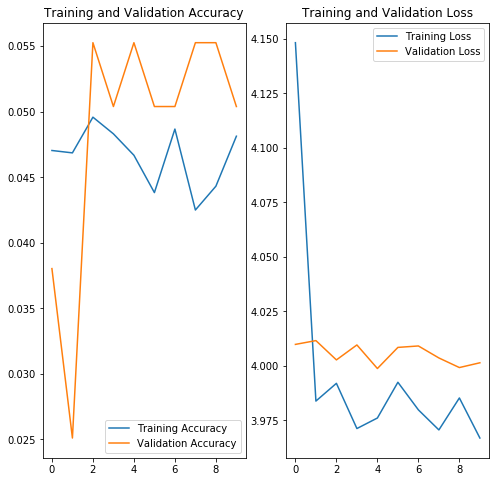

In [43]:
# Visualizing Sparse Categorical Cross Entropy Loss and Accuracy for Training and Validation Sets
accuracy = vgg16_cnnmh_dict['accuracy']
val_accuracy = vgg16_cnnmh_dict['val_accuracy']

loss = vgg16_cnnmh_dict['loss']
val_loss = vgg16_cnnmh_dict['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
plt.plot(epochs_range, val_accuracy, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

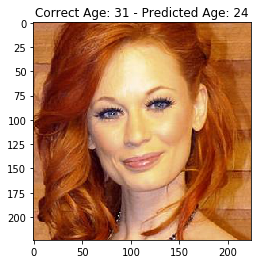

In [44]:
# Visualizing model predictions

# Transforming images into matrixes and applying resizing
test_image_addresses_list = test_image_addresses.tolist()
test_labels_list = test_labels.tolist()

correct_age = test_labels_list[image_index]
predicted_age = predicted_labels_vgg16_cnnm[image_index]

image = Image.open(test_image_addresses_list[image_index])
image = image.resize((RESIZED_WIDTH, RESIZED_HEIGHT), Image.NEAREST)
image_matrix = np.asarray(image.convert('RGB'))

# Normalizing image_matrix
image_matrix = image_matrix / 255

# Drawing train_images[image_index]
plt.figure()
plt.title(str(test_labels_list[image_index]) + " Years")
title = "Correct Age: " + str(correct_age) + " - Predicted Age: " + str(int(predicted_age))
plt.title(title)
plt.imshow(image, cmap = plt.cm.binary)
plt.grid(False)
plt.show()

### CNN Model Pre-Trained VGG-16 Classification

In [46]:
# Load the model
pretrained_vgg16_cnn_model = keras.models.load_model("pretrained_vgg16_cnn_model.h5")

# # Load the history
with open('pretrained_vgg16_cnnm.serialized','rb') as file_object:
    smh_raw_data = file_object.read()

pretrained_vgg16_cnnmh_dict = pickle.loads(smh_raw_data)

pretrained_vgg16_cnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 101)               51813     
Total params: 14,766,501
Trainable params: 51,813
Non-trainable params: 14,714,688
_________________________________________________________________


In [43]:
def make_VGG16_cnn_pretrained_model(hyperparams):
    # Defining shape
    input_shape = (RESIZED_WIDTH, RESIZED_HEIGHT, 3)

    # Creating base model without top layers
    base_model = tf.keras.applications.VGG16(
      input_shape = input_shape,
      include_top = False,
      weights = 'imagenet'
    )

    # Avoid existent layers weights to be recalculated 
    base_model.trainable = False

    # Create top layers
    number_of_classes = 101
    global_average_layer = tf.keras.layers.GlobalMaxPooling2D()
    prediction_layer = tf.keras.layers.Dense(number_of_classes, activation = 'linear')

    # Create final model
    model = tf.keras.Sequential([
        base_model,
        global_average_layer,
        prediction_layer
    ])

    return model

    #GlobalMaxPooling
    #Regression
    #Check Validation and Train Distributions
    #ClassWiights - Balance Datasets

In [42]:
# Creating model
pretrained_vgg16_cnn_model = make_VGG16_cnn_pretrained_model(hyperparams)

# Compiling model
pretrained_vgg16_cnn_model.compile(optimizer = 'adam', 
                                  loss = 'sparse_categorical_crossentropy', 
                                  metrics = ['accuracy'])

pretrained_vgg16_cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


In [44]:
# Training the model
pretrained_vgg16_cnnm_history = pretrained_vgg16_cnn_model.fit_generator(
    steps_per_epoch = train_df_size // batch_size,
    generator = train_data_gen, 
    validation_data = validation_data_gen, 
    validation_steps = train_df_size // batch_size, 
    epochs = epochs
)

pretrained_vgg16_cnnmh_dict = pretrained_vgg16_cnnm_history.history

Epoch 1/10
173/173 [==============================] - 4444s 26s/step - loss: 4.0541 - accuracy: 0.0441 - val_loss: 3.9847 - val_accuracy: 0.0362
Epoch 2/10
173/173 [==============================] - 4604s 27s/step - loss: 3.9335 - accuracy: 0.0521 - val_loss: 3.9814 - val_accuracy: 0.0320
Epoch 3/10
173/173 [==============================] - 4089s 24s/step - loss: 3.8860 - accuracy: 0.0572 - val_loss: 3.9648 - val_accuracy: 0.0465
Epoch 4/10
173/173 [==============================] - 3977s 23s/step - loss: 3.8657 - accuracy: 0.0575 - val_loss: 3.9451 - val_accuracy: 0.0433
Epoch 5/10
173/173 [==============================] - 4135s 24s/step - loss: 3.8228 - accuracy: 0.0630 - val_loss: 3.9610 - val_accuracy: 0.0397
Epoch 6/10
173/173 [==============================] - 4291s 25s/step - loss: 3.7989 - accuracy: 0.0668 - val_loss: 3.9466 - val_accuracy: 0.0466
Epoch 7/10
173/173 [==============================] - 4058s 23s/step - loss: 3.7694 - accuracy: 0.0674 - val_loss: 3.9235 - val_ac

In [45]:
# Save the Model
pretrained_vgg16_cnn_model.save("pretrained_vgg16_cnn_model.h5")

# Save the history
pretrained_vgg16_cnnmh_serialized = pickle.dumps(pretrained_vgg16_cnnm_history.history)

with open('pretrained_vgg16_cnnm.serialized', 'wb') as file_object:
    file_object.write(pretrained_vgg16_cnnmh_serialized)

In [48]:
# Print resulting cnn_model metrics for train
train_scce_pretrained_vgg16_cnnm, train_accuracy_pretrained_vgg16_cnnm = pretrained_vgg16_cnn_model.evaluate_generator(train_data_gen)

print("Train Sparse Categorical Cross Entropy Pretrained VGG16 CNN Model: {}".format(train_scce_pretrained_vgg16_cnnm))
print("Train Accuracy Pretrained VGG16 CNN Model: {}".format(train_accuracy_pretrained_vgg16_cnnm))

Train Sparse Categorical Cross Entropy Pretrained VGG16 CNN Model: 3.9624176025390625
Train Accuracy Pretrained VGG16 CNN Model: 0.04653659462928772


In [49]:
# Print resulting cnn_model metrics for test
test_scce_pretrained_vgg16_cnnm, test_accuracy_pretrained_vgg16_cnnm = pretrained_vgg16_cnn_model.evaluate_generator(test_data_gen)

print("Test Sparse Categorical Cross Entropy Pretrained VGG16 CNN Model: {}".format(test_scce_pretrained_vgg16_cnnm))
print("Test Accuracy Pretrained VGG16 CNN Model: {}".format(test_accuracy_pretrained_vgg16_cnnm))

Test Sparse Categorical Cross Entropy Pretrained VGG16 CNN Model: 3.963336560815413
Test Accuracy Pretrained VGG16 CNN Model: 0.04665551707148552


In [50]:
# Predicting with test data
predicted_probability_labels_pretrained_vgg16_cnnm = pretrained_vgg16_cnn_model.predict_generator(test_data_gen)

In [51]:
# Calculating max probability items in predicted probability items list
predicted_labels_pretrained_vgg16_cnnm = []

for prediction_for_image in predicted_probability_labels_pretrained_vgg16_cnnm:
    max_probability_predicted_value = np.argmax(prediction_for_image)
    predicted_labels_pretrained_vgg16_cnnm.append(max_probability_predicted_value)

# Calculating some more metrics
test_mse_pretrained_vgg16_cnnm = mean_squared_error(test_labels, predicted_labels_pretrained_vgg16_cnnm)
print("Mean Square Error (MSE)= {:.2f}".format(test_mse_pretrained_vgg16_cnnm))

test_mae_pretrained_vgg16_cnnm = mean_absolute_error(test_labels, predicted_labels_pretrained_vgg16_cnnm)
print("Mean Absolute Error (MAE)= {:.2f}".format(test_mae_pretrained_vgg16_cnnm))

test_r2_pretrained_vgg16_cnnm = r2_score(test_labels, predicted_labels_pretrained_vgg16_cnnm)
print("R_2 = {:.3f}".format(test_r2_pretrained_vgg16_cnnm))

Mean Square Error (MSE)= 427.32
Mean Absolute Error (MAE)= 14.17
R_2 = -0.570


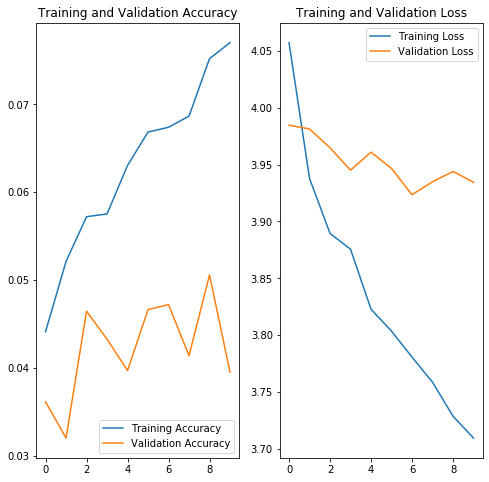

In [52]:
# Visualizing Sparse Categorical Cross Entropy Loss and Accuracy for Training and Validation Sets
accuracy = pretrained_vgg16_cnnmh_dict['accuracy']
val_accuracy = pretrained_vgg16_cnnmh_dict['val_accuracy']

loss = pretrained_vgg16_cnnmh_dict['loss']
val_loss = pretrained_vgg16_cnnmh_dict['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
plt.plot(epochs_range, val_accuracy, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

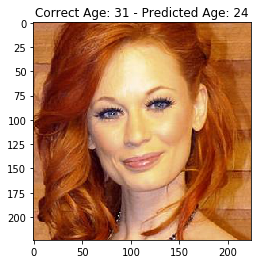

In [53]:
# Visualizing model predictions

# Transforming images into matrixes and applying resizing
test_image_addresses_list = test_image_addresses.tolist()
test_labels_list = test_labels.tolist()

correct_age = test_labels_list[image_index]
predicted_age = predicted_labels_pretrained_vgg16_cnnm[image_index]

image = Image.open(test_image_addresses_list[image_index])
image = image.resize((RESIZED_WIDTH, RESIZED_HEIGHT), Image.NEAREST)
image_matrix = np.asarray(image.convert('RGB'))

# Normalizing image_matrix
image_matrix = image_matrix / 255

# Drawing train_images[image_index]
plt.figure()
plt.title(str(test_labels_list[image_index]) + " Years")
title = "Correct Age: " + str(correct_age) + " - Predicted Age: " + str(int(predicted_age))
plt.title(title)
plt.imshow(image, cmap = plt.cm.binary)
plt.grid(False)
plt.show()

### CNN Model Pre-Trained VGG-16 Regression

In [ ]:
# Load the model
pretrained_vgg16_cnn_regression_model = keras.models.load_model("pretrained_vgg16_cnn_regression_model.h5")

# # Load the history
with open('pretrained_vgg16_cnnrm.serialized','rb') as file_object:
    smh_raw_data = file_object.read()

pretrained_vgg16_cnnrmh_dict = pickle.loads(smh_raw_data)

pretrained_vgg16_cnn_regression_model.summary()

In [25]:
def make_VGG16_cnn_pretrained_regression_model(hyperparams):
    # Defining shape
    input_shape = (RESIZED_WIDTH, RESIZED_HEIGHT, 3)

    # Creating base model without top layers
    base_model = tf.keras.applications.VGG16(
      input_shape = input_shape,
      include_top = False,
      weights = 'imagenet'
    )

    # Avoid existent layers weights to be recalculated 
    base_model.trainable = False

    # Create top layers
    number_of_classes = 1
    global_average_layer = tf.keras.layers.GlobalMaxPooling2D()
    prediction_layer = tf.keras.layers.Dense(number_of_classes)

    # Create final model
    model = tf.keras.Sequential([
        base_model,
        global_average_layer,
        prediction_layer
    ])

    return model

In [28]:
# Creating model
pretrained_vgg16_cnn_regression_model = make_VGG16_cnn_pretrained_regression_model(hyperparams)

# Compiling model
pretrained_vgg16_cnn_regression_model.compile(optimizer = 'adam', 
                                              loss = 'mse', 
                                              metrics = ['mae'])

pretrained_vgg16_cnn_regression_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 513       
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


In [29]:
# Training the model
pretrained_vgg16_cnnrm_history = pretrained_vgg16_cnn_regression_model.fit_generator(
    steps_per_epoch = train_df_size // batch_size,
    generator = train_data_gen, 
    validation_data = validation_data_gen, 
    validation_steps = train_df_size // batch_size, 
    epochs = epochs
)

pretrained_vgg16_cnnrmh_dict = pretrained_vgg16_cnnrm_history.history

Epoch 1/10
33/33 [==============================] - 749s 23s/step - loss: 1236.7641 - mae: 31.1156 - val_loss: 666.4580 - val_mae: 22.5063
Epoch 2/10
33/33 [==============================] - 762s 23s/step - loss: 769.3176 - mae: 22.2073 - val_loss: 382.6849 - val_mae: 15.0293
Epoch 3/10
33/33 [==============================] - 745s 23s/step - loss: 476.8262 - mae: 15.8664 - val_loss: 293.1256 - val_mae: 13.4845
Epoch 4/10
33/33 [==============================] - 777s 24s/step - loss: 388.5656 - mae: 14.5808 - val_loss: 282.8815 - val_mae: 13.7203
Epoch 5/10
33/33 [==============================] - 766s 23s/step - loss: 380.8720 - mae: 14.9054 - val_loss: 291.2169 - val_mae: 14.1634
Epoch 6/10
33/33 [==============================] - 792s 24s/step - loss: 329.2993 - mae: 14.2539 - val_loss: 297.2968 - val_mae: 14.4247
Epoch 7/10
33/33 [==============================] - 791s 24s/step - loss: 349.4019 - mae: 14.5765 - val_loss: 297.0301 - val_mae: 14.4607
Epoch 8/10
33/33 [===============

In [30]:
# Save the Model
pretrained_vgg16_cnn_regression_model.save("pretrained_vgg16_cnn_regression_model.h5")

# Save the history
pretrained_vgg16_cnnrmh_serialized = pickle.dumps(pretrained_vgg16_cnnrm_history.history)

with open('pretrained_vgg16_cnnrm.serialized', 'wb') as file_object:
    file_object.write(pretrained_vgg16_cnnrmh_serialized)

In [31]:
# Print resulting cnn_model metrics for train
train_mse_pretrained_vgg16_cnnrm, train_mae_pretrained_vgg16_cnnrm = pretrained_vgg16_cnn_regression_model.evaluate_generator(train_data_gen)

print("Train MSE CNN Model: {}".format(train_mse_pretrained_vgg16_cnnrm))
print("Train MAE CNN Model: {}".format(train_mae_pretrained_vgg16_cnnrm))

Train MSE CNN Model: 329.7836067445817
Train MAE CNN Model: 14.296072959899902


In [32]:
# Print resulting cnn_model metrics for test
test_mse_pretrained_vgg16_cnnrm, test_mae_pretrained_vgg16_cnnrm = pretrained_vgg16_cnn_regression_model.evaluate_generator(test_data_gen)

print("Test MSE CNN Model: {}".format(test_mse_pretrained_vgg16_cnnrm))
print("Test MAE CNN Model: {}".format(test_mae_pretrained_vgg16_cnnrm))

Test MSE CNN Model: 375.5789031982422
Test MAE CNN Model: 15.244267463684082


In [33]:
# Predicting with test data
predicted_labels_pretrained_vgg16_cnnrm = pretrained_vgg16_cnn_regression_model.predict_generator(test_data_gen)

# Calculating some more metrics
test_mse_pretrained_vgg16_cnnrm = mean_squared_error(test_labels, predicted_labels_pretrained_vgg16_cnnrm)
print("Mean Square Error (MSE)= {:.2f}".format(test_mse_pretrained_vgg16_cnnrm))

test_mae_pretrained_vgg16_cnnrm = mean_absolute_error(test_labels, predicted_labels_pretrained_vgg16_cnnrm)
print("Mean Absolute Error (MAE)= {:.2f}".format(test_mae_pretrained_vgg16_cnnrm))

test_r2_pretrained_vgg16_cnnrm = r2_score(test_labels, predicted_labels_pretrained_vgg16_cnnrm)
print("R_2 = {:.3f}".format(test_r2_pretrained_vgg16_cnnrm))

Mean Square Error (MSE)= 379.56
Mean Absolute Error (MAE)= 15.24
R_2 = -0.481


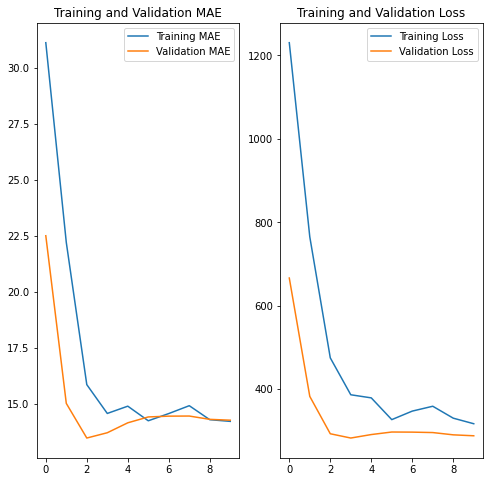

In [34]:
# Visualizing MAE and Loss for Training and Validation Sets
mae = pretrained_vgg16_cnnrmh_dict['mae']
val_mae = pretrained_vgg16_cnnrmh_dict['val_mae']

loss = pretrained_vgg16_cnnrmh_dict['loss']
val_loss = pretrained_vgg16_cnnrmh_dict['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label = 'Training MAE')
plt.plot(epochs_range, val_mae, label = 'Validation MAE')
plt.legend(loc = 'upper right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

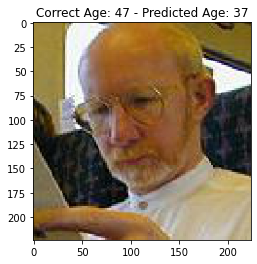

In [35]:
# Visualizing model predictions

# Transforming images into matrixes and applying resizing
test_image_addresses_list = test_image_addresses.tolist()
test_labels_list = test_labels.tolist()
predicted_test_labels_list = predicted_labels_pretrained_vgg16_cnnrm.tolist()

correct_age = test_labels_list[image_index]
predicted_age = predicted_test_labels_list[image_index][0]

image = Image.open(test_image_addresses_list[image_index])
image = image.resize((RESIZED_WIDTH, RESIZED_HEIGHT), Image.NEAREST)
image_matrix = np.asarray(image.convert('RGB'))

# Normalizing image_matrix
image_matrix = image_matrix / 255

# Drawing train_images[image_index]
plt.figure()
plt.title(str(test_labels_list[image_index]) + " Years")
title = "Correct Age: " + str(correct_age) + " - Predicted Age: " + str(int(predicted_age))
plt.title(title)
plt.imshow(image, cmap = plt.cm.binary)
plt.grid(False)
plt.show()

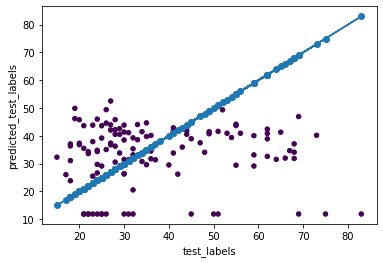

In [40]:
# Visualizing expected vs real data
N = len(test_labels)
colors = [0.8] * N
area = 20

plt.scatter(test_labels, predicted_labels_pretrained_vgg16_cnnrm, s = area, c = colors)
plt.plot(test_labels, test_labels, '-o')
plt.xlabel("test_labels")
plt.ylabel("predicted_test_labels")
plt.show()

### Loading Known People Images

In [22]:
friends_folder_base_dir = '/Users/jeffveleze/Dev/ML/Factored-AI/Datasets/AgeGenderDataSet/friends' # Local

# Create local folder data path 
friends_folder_data_path = friends_folder_base_dir + '/*' + files_extension

# Create array with friends images addresses
friends_folder_addresses = glob.glob(friends_folder_data_path)
# friends_folder_addresses = glob.glob('/Users/jeffveleze/Dev/ML/Factored-AI/Datasets/AgeGenderDataSet/friends/*.jpg')

# Initialize image_addresses empty list
friends_images_matrixes = []
friends_names = []

for address in friends_folder_addresses:
    name = address.replace(friends_folder_base_dir + '/', '')
    name = name.replace(files_extension, '')

    friends_names.append(name)
        
    image = Image.open(address)
    image = image.resize((RESIZED_WIDTH, RESIZED_HEIGHT), Image.NEAREST)
    image_matrix = np.asarray(image.convert('RGB'))

    # Normalizing image_matrix
    image_matrix = image_matrix / 255
    
    friends_images_matrixes.append(image_matrix)

np.array(friends_images_matrixes).shape

(11, 224, 224, 3)

In [23]:
def predict_friend_age(name):
    index = friends_names.index(name)

    matrix_image = friends_images_matrixes[index]
    matrix_image = np.expand_dims(matrix_image, 0)
    
    predicted_age = cnn_model.predict(matrix_image)
    
    return predicted_age[0][0]

In [24]:
predict_friend_age("Rubelio")

26.068085